In [10]:
import numpy as np
import cv2
import random
import heapq
import tensorflow as tf
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import sobel
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from skimage.measure import block_reduce

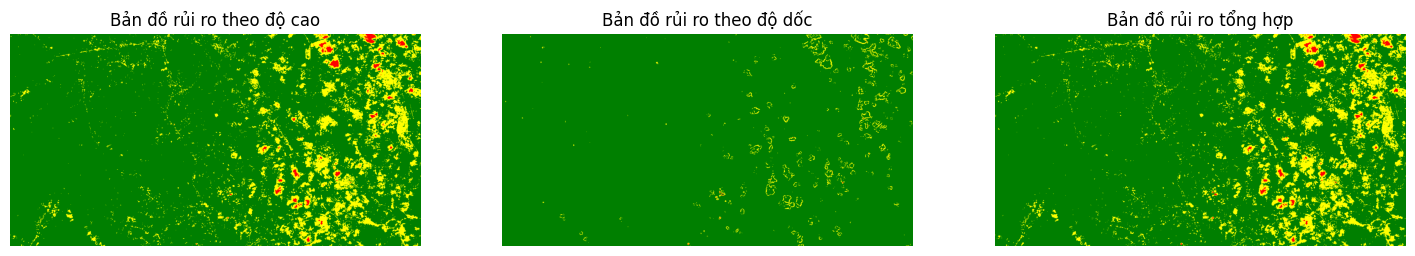

In [11]:
# Đọc dữ liệu độ cao từ file GeoTIFF
file_path = r"C:\Users\Admin\Downloads\D23022025.tif"
with rasterio.open(file_path) as dataset:
    elevation = dataset.read(1)  # Lấy kênh độ cao
    profile = dataset.profile

# Tính toán độ dốc bằng đạo hàm Sobel3
dx = sobel(elevation, axis=1)  # Gradient theo trục x
dy = sobel(elevation, axis=0)  # Gradient theo trục y
slope = np.hypot(dx, dy)  # Độ dốc tổng hợp

# Chuẩn hóa dữ liệu
elevation_norm = (elevation - np.min(elevation)) / (np.max(elevation) - np.min(elevation))
slope_norm = (slope - np.min(slope)) / (np.max(slope) - np.min(slope))

# Xây dựng bản đồ rủi ro riêng lẻ
risk_elevation = np.zeros_like(elevation_norm)
risk_slope = np.zeros_like(slope_norm)

risk_elevation[elevation_norm < 0.3] = 0  # An toàn
risk_elevation[(elevation_norm >= 0.3) & (elevation_norm < 0.7)] = 0.5  # Trung bình
risk_elevation[elevation_norm >= 0.7] = 1  # Nguy hiểm

risk_slope[slope_norm < 0.3] = 0  # An toàn
risk_slope[(slope_norm >= 0.3) & (slope_norm < 0.7)] = 0.5  # Trung bình
risk_slope[slope_norm >= 0.7] = 1  # Nguy hiểm


risk_combined = np.maximum(risk_elevation, risk_slope)

# Hàm chuyển dữ liệu rủi ro thành ảnh màu
def generate_risk_map(risk_data):
    risk_map = np.zeros((*risk_data.shape, 3))  # Ảnh màu (H, W, 3)
    risk_map[risk_data < 0.3] = [0, 0.5, 0]  # Xanh (An toàn)
    risk_map[(risk_data >= 0.3) & (risk_data < 0.7)] = [1, 1, 0]  # Vàng (Trung bình)
    risk_map[risk_data >= 0.7] = [1, 0, 0]  # Đỏ (Nguy hiểm)
    return risk_map

# Tạo ảnh màu cho 3 bản đồ
risk_map_elevation = generate_risk_map(risk_elevation)
risk_map_slope = generate_risk_map(risk_slope)
risk_map_combined = generate_risk_map(risk_combined)

# Hiển thị cả 3 bản đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(risk_map_elevation)
axes[0].set_title("Bản đồ rủi ro theo độ cao")
axes[0].axis("off")

axes[1].imshow(risk_map_slope)
axes[1].set_title("Bản đồ rủi ro theo độ dốc")
axes[1].axis("off")

axes[2].imshow(risk_map_combined)
axes[2].set_title("Bản đồ rủi ro tổng hợp")
axes[2].axis("off")

plt.show()


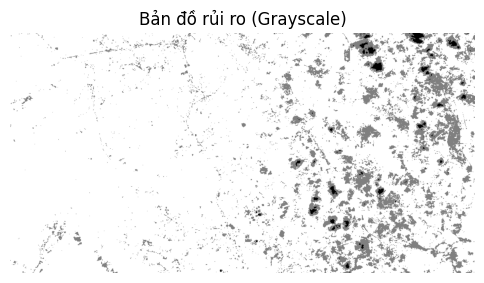

In [12]:
# Chuyển bản đồ rủi ro thành grayscale
def generate_grayscale_risk_map(risk_data):
    grayscale_map = np.zeros_like(risk_data, dtype=np.uint8)
    grayscale_map[risk_data < 0.3] = 150 # An toàn (màu xám nhạt)
    grayscale_map[(risk_data >= 0.3) & (risk_data < 0.7)] = 100 # Trung bình (xám trung bình)
    grayscale_map[risk_data >= 0.7] = 50  # Nguy hiểm (xám đậm)
    return grayscale_map

# Tạo ảnh grayscale từ risk_map_combined
grayscale_risk_map = generate_grayscale_risk_map(risk_combined)

# Hiển thị ảnh grayscale
plt.figure(figsize=(6, 6))
plt.imshow(grayscale_risk_map, cmap='gray')
plt.title("Bản đồ rủi ro (Grayscale)")
plt.axis("off")
plt.show()


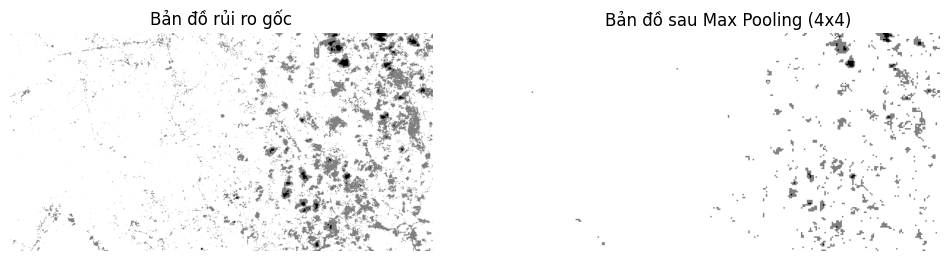

Kích thước bản đồ rủi ro ban đầu: (595, 1153)
Kích thước bản đồ rủi ro sau khi giảm: (149, 289)


In [13]:

# Hàm Max Pooling với kích thước kernel (pool_size x pool_size)
def max_pooling(image, pool_size):
    return block_reduce(image, block_size=(pool_size, pool_size), func=np.max)

# Giảm kích thước ảnh bằng Max Pooling (chọn 4 hoặc 8 tùy thuộc vào yêu cầu)
pool_size = 4  # Thay đổi thành 8 nếu muốn giảm mạnh hơn
pooled_risk_map = max_pooling(grayscale_risk_map, pool_size)

# Hiển thị ảnh gốc và ảnh sau Max Pooling
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(grayscale_risk_map, cmap="gray")
axes[0].set_title("Bản đồ rủi ro gốc")
axes[0].axis("off")

axes[1].imshow(pooled_risk_map, cmap="gray")
axes[1].set_title(f"Bản đồ sau Max Pooling ({pool_size}x{pool_size})")
axes[1].axis("off")

plt.show()
print(f"Kích thước bản đồ rủi ro ban đầu: {grayscale_risk_map.shape}")
print(f"Kích thước bản đồ rủi ro sau khi giảm: {pooled_risk_map.shape}")

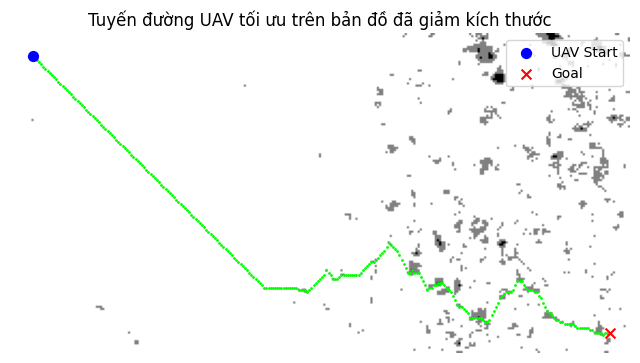

In [ ]:
# Hàm tìm đường bằng thuật toán A* với di chuyển 8 hướng
def astar(grid, start, goal):
    rows, cols = grid.shape
    open_set = []
    heapq.heappush(open_set, (0, start))  # (cost, position)

    came_from = {}
    g_score = {start: 0}
    f_score = {start: np.linalg.norm(np.array(start) - np.array(goal))}

    # Các hướng di chuyển: thẳng (4 hướng) và chéo (4 hướng)
    directions = [
        (0, 1, 1),  (1, 0, 1),  (0, -1, 1), (-1, 0, 1),   # 4 hướng thẳng
        (1, 1, 1.4), (1, -1, 1.4), (-1, 1, 1.4), (-1, -1, 1.4)  # 4 hướng chéo
    ]

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Trả về đường đi từ start -> goal

        for dx, dy, cost in directions:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                temp_g_score = g_score[current] + grid[neighbor] + cost  # Chi phí đi qua điểm này
                
                if neighbor not in g_score or temp_g_score < g_score[neighbor]:
                    g_score[neighbor] = temp_g_score
                    f_score[neighbor] = temp_g_score + np.linalg.norm(np.array(neighbor) - np.array(goal))
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
                    came_from[neighbor] = current

    return []  # Không tìm thấy đường đi

# Kích thước ảnh sau khi MaxPooling
rows, cols = pooled_risk_map.shape

# Xác định điểm xuất phát và đích (giả định UAV bắt đầu từ góc trên trái)
start = (10, 10)
goal = (rows - 10, cols - 10)

# Tìm đường đi sơ bộ
path = astar(pooled_risk_map, start, goal)

# Hiển thị ảnh với đường đi UAV
plt.figure(figsize=(8, 6))
plt.imshow(pooled_risk_map, cmap='gray')

# Vẽ đường UAV đi bằng chấm xanh lá
for (x, y) in path:
    plt.scatter(y, x, c='lime', s=1)  # Đánh dấu đường đi

# Vẽ điểm bắt đầu (UAV) bằng vòng tròn xanh dương
plt.scatter(start[1], start[0], c='blue', marker='o', s=50, label="UAV Start")

# Vẽ điểm đích bằng chữ X màu đỏ
plt.scatter(goal[1], goal[0], c='red', marker='x', s=50, label="Goal")

plt.title("Tuyến đường UAV tối ưu trên bản đồ đã giảm kích thước")
plt.legend()
plt.axis("off")
plt.show()

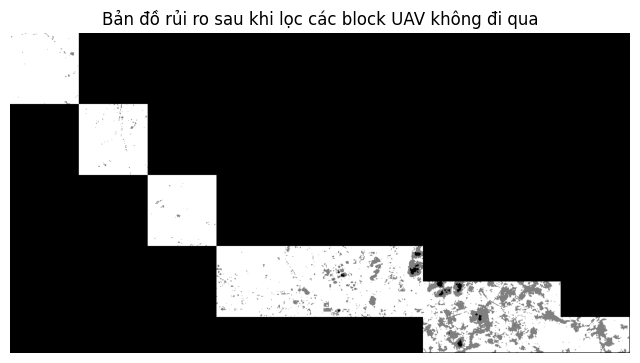

In [ ]:

# Kích thước ảnh gốc và ảnh đã MaxPooling
orig_height, orig_width = grayscale_risk_map.shape
pool_height, pool_width = pooled_risk_map.shape

# Xác định số lượng block theo chiều cao và chiều rộng
num_blocks_y = 9  # Hoặc có thể là 25 tùy vào mức độ chi tiết
num_blocks_x = 9

# Kích thước mỗi block trên ảnh gốc và ảnh đã giảm kích thước
block_size_y_orig = orig_height // num_blocks_y
block_size_x_orig = orig_width // num_blocks_x
block_size_y_pool = pool_height // num_blocks_y
block_size_x_pool = pool_width // num_blocks_x

# Đánh số block trên ảnh đã MaxPooling
block_index_map = np.zeros((num_blocks_y, num_blocks_x), dtype=int)
block_counter = 1
for i in range(num_blocks_y):
    for j in range(num_blocks_x):
        block_index_map[i, j] = block_counter
        block_counter += 1

# Ghi lại block UAV đã đi qua trên ảnh nhỏ
blocks_traversed = set()
for (x, y) in path:
    block_x = y // block_size_x_pool  # Chia để xác định block
    block_y = x // block_size_y_pool
    blocks_traversed.add((block_y, block_x))

# Đối chiếu block UAV đi qua trên ảnh nhỏ lên ảnh gốc
new_risk_map = np.full_like(grayscale_risk_map, 50)  # Đặt tất cả thành mức nguy hiểm cao nhất

for (block_y, block_x) in blocks_traversed:
    # Xác định tọa độ block trên ảnh gốc
    start_y = block_y * block_size_y_orig
    end_y = start_y + block_size_y_orig
    start_x = block_x * block_size_x_orig
    end_x = start_x + block_size_x_orig
    
    # Giữ nguyên mức nguy hiểm tại các block UAV có thể đi qua
    new_risk_map[start_y:end_y, start_x:end_x] = grayscale_risk_map[start_y:end_y, start_x:end_x]

# Hiển thị ảnh mới với các block UAV không đi qua được đánh dấu nguy hiểm cao nhất
plt.figure(figsize=(8, 6))
plt.imshow(new_risk_map, cmap='gray')
plt.title("Bản đồ rủi ro sau khi lọc các block UAV không đi qua")
plt.axis("off")
plt.show()


In [ ]:
# DQN Agent
class DQN_Agent:
    def __init__(self, state_size, action_size, model_path="dqn_model.h5"):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.002
        self.model = self.build_model()
        self.model_path = model_path

        # Load mô hình nếu có
        self.load_model()

    def build_model(self):
        model = Sequential([
            Dense(24, input_dim=self.state_size, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model
    
    def save_model(self):
        """ Lưu trọng số mô hình và epsilon để tiếp tục huấn luyện """
        self.model.save(self.model_path)
        with open(self.model_path.replace(".h5", "_epsilon.txt"), "w") as f:
            f.write(str(self.epsilon))
        print(f"Đã lưu mô hình vào {self.model_path}")

    def load_model(self):
        """ Tải mô hình đã lưu nếu tồn tại """
        if os.path.exists(self.model_path):
            self.model = tf.keras.models.load_model(self.model_path)
            epsilon_path = self.model_path.replace(".h5", "_epsilon.txt")
            if os.path.exists(epsilon_path):
                with open(epsilon_path, "r") as f:
                    self.epsilon = float(f.read().strip())
            print(f"Đã tải mô hình từ {self.model_path}, Epsilon: {self.epsilon:.4f}")
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.array(state).reshape(1, -1)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])
    
    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = np.array(next_state).reshape(1, -1)
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0))
            state = np.array(state).reshape(1, -1)
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


class UAV_Env:
    def __init__(self, risk_map, start, goal):
        self.risk_map = risk_map
        self.start = start
        self.goal = goal
        self.state = start
        self.actions = [
            ((0, 1), 1), ((1, 0), 1), ((0, -1), 1), ((-1, 0), 1),  # Lên, Xuống, Trái, Phải
            ((1, 1), 1.4), ((1, -1), 1.4), ((-1, 1), 1.4), ((-1, -1), 1.4) # Đường chéo
        ]
        self.rows, self.cols = risk_map.shape[:2]
        self.steps_in_risk = 0  # Đếm số bước UAV đi trong vùng nguy hiểm
        self.MAX_STEPS_IN_RISK = 6  # Giới hạn số bước UAV có thể tồn tại trong vùng nguy hiểm
        self.max_consecutive_failures = 50  # Giới hạn số lần UAV đi xa khỏi đích liên tiếp
        self.consecutive_failures = 0

    def reset(self):
        self.state = self.start
        self.steps_in_risk = 0  # Reset bộ đếm vùng nguy hiểm khi bắt đầu lại
        self.consecutive_failures = 0
        return self.state

    def step(self, action):
        """ Thực hiện hành động và trả về (next_state, reward, done) """
        (dr, dc), move_cost = self.actions[action]
        row, col = self.state
        new_row, new_col = row + dr, col + dc

        if not (0 <= new_row < self.rows and 0 <= new_col < self.cols):
            new_row, new_col = row, col  # Giữ nguyên vị trí nếu đi ra ngoài bản đồ

        self.state = (new_row, new_col)  # Cập nhật vị trí UAV

        old_distance = abs(row - self.goal[0]) + abs(col - self.goal[1])
        new_distance = abs(new_row - self.goal[0]) + abs(new_col - self.goal[1])

        if self.state == self.goal:
            reward = 5000  # Tăng phần thưởng để khuyến khích UAV đến đích
            done = True
        elif self.risk_map[self.state] >= 0.8:
            if new_distance < old_distance:
                self.steps_in_risk -= 1
                reward = -1 - move_cost
            else:
                self.steps_in_risk += 1
                reward = -10 - move_cost
            done = self.steps_in_risk >= self.MAX_STEPS_IN_RISK
        else:
            if new_distance < old_distance:
                reward =  (old_distance - new_distance) * 2 - move_cost
                self.consecutive_failures = 0
            else:
                reward =  - move_cost
                self.consecutive_failures += 1
            done = self.consecutive_failures >= self.max_consecutive_failures

        return self.state, reward, done
    def render(self, path=[]):
        img = (self.risk_map * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        for (r, c) in path:
            cv2.circle(img, (c, r), 1, (0, 255, 255), -1)  # Đường đi màu Cyan

        plt.imshow(img)
        plt.scatter(self.start[1], self.start[0], color="green", marker="o", label="Start")
        plt.scatter(self.goal[1], self.goal[0], color="red", marker="x", label="Goal")
        plt.legend()
        plt.title("DQN UAV Pathfinding")
        plt.axis("off")
        plt.show()


# Load Risk Map
risk_map = risk_map_combined[:, :, 0]
start = (50, 50)
goal = (500, 750)

env = UAV_Env(risk_map, start, goal)
agent = DQN_Agent(state_size=2, action_size=len(env.actions))

episodes = 50
for e in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    path = []
    
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        path.append(state)
    
    agent.train()
    
    print(f"Episode {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.4f}")
    
    if e % 5 == 0:
        env.render(path)
    
    if e % 10 == 0:
        agent.save_model()
